In [1]:
import os
import cv2
import math
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from doctr.models import detection_predictor, recognition_predictor, page_orientation_predictor, crop_orientation_predictor
from doctr.io import DocumentFile
from doctr.utils.geometry import detach_scores
from scipy.stats import median_abs_deviation
from sklearn.covariance import MinCovDet
from sklearn.cluster import DBSCAN
from sklearn.cluster import HDBSCAN
from scipy.stats import chi2
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, fcluster
import largestinteriorrectangle as lir
from skimage.morphology import skeletonize

EPS = 1e-6

### Functions

In [2]:

def preprocess(img):
    _, thresh_otsu = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU)

    return thresh_otsu

def detect_bboxes(img):
    # convert img to bytes
    _, img_encoded = cv2.imencode('.png', img)
    img_encoded = img_encoded.tobytes()
    # Helper function to convert relative coordinates to absolute pixel values
    def _to_absolute(geom, img_shape: tuple[int, int]) -> list[list[int]]:
        h, w = img_shape
        if len(geom) == 2:  # Assume straight pages = True -> [[xmin, ymin], [xmax, ymax]]
            (xmin, ymin), (xmax, ymax) = geom
            xmin, xmax = int(round(w * xmin)), int(round(w * xmax))
            ymin, ymax = int(round(h * ymin)), int(round(h * ymax))
            return [[xmin, ymin], [xmax, ymin], [xmax, ymax], [xmin, ymax]]
        else:  # For polygons, convert each point to absolute coordinates
            return [[int(point[0] * w), int(point[1] * h)] for point in geom]

    # Define the detection predictor
    det_predictor = detection_predictor(
        arch="db_resnet50",
        pretrained=True,
        assume_straight_pages=True,
        symmetric_pad=True,
        preserve_aspect_ratio=True,
        batch_size=1,
    )  # .cuda().half()  # Uncomment this line if you have a GPU

    # Define the postprocessing parameters (optional)
    det_predictor.model.postprocessor.bin_thresh = 0.3
    det_predictor.model.postprocessor.box_thresh = 0.1

    # Load the document image
    docs = DocumentFile.from_images([img_encoded])
    results = det_predictor(docs)

    bboxes = []
    for doc, res in zip(docs, results):
        img_shape = (doc.shape[0], doc.shape[1])
        # Detach the probability scores from the results
        detached_coords, prob_scores = detach_scores([res.get("words")])

        for i, coords in enumerate(detached_coords[0]):
            coords = coords.reshape(2, 2).tolist() if coords.shape == (4,) else coords.tolist()

            # Convert relative to absolute pixel coordinates
            points = np.array(_to_absolute(coords, img_shape), dtype=np.int32).reshape((-1, 1, 2))
            bboxes.append(points)
    return  np.squeeze(np.array(bboxes), axis=2)


def contours_in_bboxes(bboxes, contours_list, include_border=True):
    inside = []
    test_threshold = 0 if include_border else 1

    # Precompute axis-aligned bounding rects for a quick AABB-reject
    contour_brects = [cv2.boundingRect(c) for c in contours_list]

    for bb in bboxes:
        # make sure our polygon is shape (4,1,2) and int32
        poly = bb.reshape(-1,1,2).astype(np.int32)

        # compute its AABB
        xs, ys = bb[:,0], bb[:,1]
        x0, x1 = xs.min(), xs.max()
        y0, y1 = ys.min(), ys.max()

        box_inside = []
        for ctr, (cx, cy, w, h) in zip(contours_list, contour_brects):
            # fast AABB reject
            if cx < x0 or cy < y0 or (cx+w) > x1 or (cy+h) > y1:
                continue

            # flatten contour to Nx2
            pts = ctr.reshape(-1, 2)
            # test each point
            all_inside = True
            for (x_np, y_np) in pts:
                # convert to native Python floats
                x, y = float(x_np), float(y_np)
                dist = cv2.pointPolygonTest(poly, (x, y), False)
                if dist < test_threshold:
                    all_inside = False
                    break

            if all_inside:
                box_inside.append(ctr)

        inside.append(box_inside)

    return inside

def is_circle_enclosing(contour, threshold):
    (x, y), radius = cv2.minEnclosingCircle(contour)
    enclosing_area = np.pi * (radius ** 2) + EPS
    contour_area = cv2.contourArea(contour)
    
    return contour_area / enclosing_area > threshold 

def is_rectangle_enclosing(contour, threshold):
    rect = cv2.minAreaRect(contour)
    box_area = rect[1][0] * rect[1][1] + EPS
    contour_area = cv2.contourArea(contour)
    
    if box_area == 0:
        return False
        
    return contour_area / box_area > threshold


### Load

In [3]:

# img_path = r'C:\Users\samoed\Documents\GitHub\diploma_bachelor\data\else\contour.png'
# img_path = r'C:\Users\samoed\Documents\GitHub\diploma_bachelor\data\else\huge.png'
# img_path = r'C:\Users\samoed\Documents\GitHub\diploma_bachelor\data\local\simple_petri_6.png'
# img_path = r'C:\Users\samoed\Documents\GitHub\diploma_bachelor\data\internet\petri_net_2.png'
# img_path = r'C:\Users\samoed\Documents\GitHub\diploma_bachelor\data\internet\petri_net_13.jpg'
# img_path = r'C:\Users\samoed\Documents\GitHub\diploma_bachelor\data\upscaled\better_res\mp_2.png'
# img_path = r'C:\Users\samoed\Documents\GitHub\diploma_bachelor\data\upscaled\better_res\mp_1.png'
# img_path = r'C:\Users\samoed\Documents\GitHub\diploma_bachelor\data\internet\petri_net_19.jpg'
img_path = '../data/local/mid_petri_2.png' # Example relative path
try:
    with open(img_path, 'r') as f:
        pass
except FileNotFoundError:
    print(f"File {img_path} not found.")
    exit(1)
img = cv2.imread(img_path)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Upscaling heuristic
min_dimension_threshold = 800
upscale_factor = 2
h, w = img_gray.shape
if h < min_dimension_threshold or w < min_dimension_threshold:
    print(f"Image dimensions ({w}x{h}) are below threshold ({min_dimension_threshold}px). Upscaling by {upscale_factor}x.")
    img_gray = cv2.resize(img_gray, (w * upscale_factor, h * upscale_factor), interpolation=cv2.INTER_LANCZOS4)
    # Also resize the original color image if it's used later for display, to maintain consistency
    img = cv2.resize(img, (w * upscale_factor, h * upscale_factor), interpolation=cv2.INTER_LANCZOS4)
    print(f"New image dimensions: {img_gray.shape[1]}x{img_gray.shape[0]}")

img_inverted = cv2.bitwise_not(img_gray)

preprocessed_img = preprocess(img_inverted)

Image dimensions (1057x619) are below threshold (800px). Upscaling by 2x.
New image dimensions: 2114x1238


### Text detect and remove

In [4]:
def remove_text(preprocessed_img, bboxes):

    contours_list, hierarchy = cv2.findContours(preprocessed_img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE) 
    ## display contours
    # for i, contour in enumerate(contours_list):
    #     cv2.drawContours(img, [contour], -1, (0, 255, 0), 2)

    text_contours = contours_in_bboxes(bboxes, contours_list)
    # ## display all results
    # for i, box in enumerate(text_contours):
    #     for j, contour in enumerate(box):
    #         cv2.drawContours(img, [contour], -1, (0, 255, 0), 2)

    # Create a blank mask with the same dimensions as preprocessed_img
    text_mask = np.ones_like(preprocessed_img)
    for text_contour in text_contours:
        cv2.drawContours(text_mask, text_contour, -1, (0), thickness=cv2.FILLED)
    img_no_text = cv2.bitwise_and(preprocessed_img, preprocessed_img, mask=text_mask)

    return img_no_text

bboxes = detect_bboxes(img) ### TODO: it was image here
img_no_text = remove_text(preprocessed_img, bboxes)
preprocessed_img = img_no_text
Image.fromarray(preprocessed_img).show()

### Empty node detection

In [5]:

def fill_empty_nodes(preprocessed_img):
    contours_list, hierarchy = cv2.findContours(preprocessed_img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE) 
    # draw each contour with a different random color
    draw_img = preprocessed_img.copy()
    for i, contour in enumerate(contours_list):
        cv2.drawContours(img, [contour], -1, (np.random.randint(0, 256), np.random.randint(0, 256), np.random.randint(0, 256)), 2)
    Image.fromarray(img).show()

    # print("Contours list length: ", len(contours_list))
    # for i, contour in enumerate(contours_list):
    #     rect = cv2.minAreaRect(contour)
    #     box_area = rect[1][0] * rect[1][1] + EPS
    #     contour_area = cv2.contourArea(contour)
        
    #     print(f"Contour {i} is {contour_area / box_area } rectangle")

    # # draw all contours on separate images and show them

    # contour = contours_list[6]
    # contour_img = np.zeros_like(img)
    # cv2.drawContours(contour_img, [contour], -1, (255, 255, 255), 1)
    # Image.fromarray(contour_img).show()


    ### TODO: Rewrite to detect based on inscribed circle and rectangle and put these parameters in user parameters
    # Filter for circular contours
    contours_of_interest = []
    for i, contour in enumerate(contours_list):
        if is_circle_enclosing(contour, 0.8) or is_rectangle_enclosing(contour, 0.95):
            contours_of_interest.append(contour)

    # contour_img = np.zeros_like(img)
    # cv2.drawContours(contour_img, contours_of_interest, -1, (255, 255, 255), 1)
    # Image.fromarray(contour_img).show()

    ### add 255 pixels inside the found contours on the preprocessed_img
    img_empty_nodes_filled = preprocessed_img.copy()
    for contour in contours_of_interest:
        cv2.drawContours(img_empty_nodes_filled, [contour], -1, (255), thickness=cv2.FILLED)

    return img_empty_nodes_filled

img_empty_nodes_filled = fill_empty_nodes(preprocessed_img)
Image.fromarray(img_empty_nodes_filled).show()


### Erosion heuristic

In [6]:
def get_nodes_mask(preprocessed_img):
    ### Iterative erosion to remove edges and identify nodes
    image_for_erosion = preprocessed_img.copy() # Start with the image after filling contours

    kernel_erosion = np.ones((3,3), np.uint8)

    erosion_counts_history = [] 
    temp_eroded_img_in_loop = image_for_erosion.copy()

    num_optimal_erosions = 0

    # Parameters for heuristic
    min_stable_length = 3  # Number of consecutive identical contour counts to declare stability
    max_erosion_iterations = 30 # Max number of erosion steps to try

    found_optimal_stability = False
    actual_erosions_performed_in_loop = 0

    for k_step in range(1, max_erosion_iterations + 1):
        actual_erosions_performed_in_loop = k_step
        # Perform one more erosion on the cumulatively eroded image
        current_eroded_step_img = cv2.erode(temp_eroded_img_in_loop, kernel_erosion, iterations=1)
        contours, _ = cv2.findContours(current_eroded_step_img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        num_contours_at_step = len(contours)
        erosion_counts_history.append(num_contours_at_step)
        
        temp_eroded_img_in_loop = current_eroded_step_img # Update for next iteration or if loop breaks

        if len(erosion_counts_history) >= min_stable_length:
            # Check if the last 'min_stable_length' counts are identical
            last_n_counts = erosion_counts_history[-min_stable_length:]
            if all(c == last_n_counts[0] for c in last_n_counts):
                # Stability detected. Optimal erosions = start of this stable sequence.
                num_optimal_erosions = actual_erosions_performed_in_loop - min_stable_length + 1
                print(f"Stability detected: Contour count {last_n_counts[0]} stable for {min_stable_length} steps.")
                print(f"Optimal number of erosions determined as: {num_optimal_erosions}.")
                found_optimal_stability = True
                break 

        if num_contours_at_step == 0 and actual_erosions_performed_in_loop > 0:
            print(f"All contours disappeared after {actual_erosions_performed_in_loop} erosions.")
            if not found_optimal_stability: # If stability wasn't found before this
                    num_optimal_erosions = actual_erosions_performed_in_loop 
            found_optimal_stability = True # Consider this a stopping condition
            break
    # Loop ends

    if not found_optimal_stability:
        num_optimal_erosions = actual_erosions_performed_in_loop # Use all erosions if max_iterations reached
        print(f"Max erosions ({max_erosion_iterations}) reached or no stable sequence found. Using {num_optimal_erosions} erosions.")

    # Obtain the node mask after 'num_optimal_erosions'
    node_mask_eroded = image_for_erosion # Default if num_optimal_erosions is 0
    if num_optimal_erosions > 0:
        # Re-erode the original filled image by the optimal number of steps
        node_mask_eroded = cv2.erode(image_for_erosion, kernel_erosion, iterations=num_optimal_erosions)
        print(f"Applied {num_optimal_erosions} erosions to get the node mask.")
    else:
        print("No erosions applied to get node mask (0 optimal erosions).")

    # Dilate the eroded node mask to recover node sizes
    dilated_node_mask = node_mask_eroded # Default if no dilation needed
    if num_optimal_erosions > 0:
        # Dilate by the same number of steps as optimal erosions
        kernel_dilation = kernel_erosion # Using the same kernel for dilation
        dilated_node_mask = cv2.dilate(node_mask_eroded, kernel_dilation, iterations=num_optimal_erosions)
        print(f"Applied {num_optimal_erosions} dilations to recover node sizes.")
    else:
        print("No dilations applied (0 optimal erosions).")

    print(f"Contour counts per erosion step: {erosion_counts_history}")

    return dilated_node_mask

nodes_mask = get_nodes_mask(img_empty_nodes_filled) 
Image.fromarray(nodes_mask).show()

Stability detected: Contour count 31 stable for 3 steps.
Optimal number of erosions determined as: 6.
Applied 6 erosions to get the node mask.
Applied 6 dilations to recover node sizes.
Contour counts per erosion step: [936, 72, 69, 69, 42, 31, 31, 31]


### Inscribed node detection

In [7]:

def detect_shapes(preprocessed_img):
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(preprocessed_img, connectivity=8)
    blob_masks = []

    for label in range(1, num_labels):
        blob_mask = np.zeros_like(preprocessed_img, dtype=np.uint8)
        blob_mask[labels == label] = 255
        blob_masks.append(blob_mask)


    circles = []
    rectangles = []


    for i, blob_mask in enumerate(blob_masks):
        ### Find inscribed circles
        dist = cv2.distanceTransform(blob_mask, cv2.DIST_L2, 0)
        NULL,max_val,NULL,max_indx=cv2.minMaxLoc(dist)

        (x,y),radius = max_indx, int(max_val)

        circle_mask = np.zeros_like(blob_mask)
        cv2.circle(circle_mask, (x,y), radius, (255), thickness=cv2.FILLED)

        ### find the overlap between the area of the circle and the area of the blob_mask from 0 to 1
        overlap = cv2.bitwise_and(blob_mask, circle_mask)
        overlap_area = cv2.countNonZero(overlap)
        blob_area = cv2.countNonZero(blob_mask)
        circle_overlap_percentage = overlap_area / blob_area 
        print("Overlap percentage between circle and mask: ", circle_overlap_percentage)

        # if circle_overlap_percentage > 0.8: ### TODO: User Parameter
        #     cv2.circle(img, (x,y), radius, (0,255,0), 2)




        bool_blob_mask = blob_mask.astype(np.bool)
        rectangle = lir.lir(bool_blob_mask)

        rectangle_mask = np.zeros_like(blob_mask)
        cv2.rectangle(rectangle_mask, lir.pt1(rectangle), lir.pt2(rectangle), (255), thickness=cv2.FILLED)

        ### find the overlap between the area of the rectangle and the area of the blob_mask from 0 to 1
        overlap = cv2.bitwise_and(blob_mask, rectangle_mask)
        overlap_area = cv2.countNonZero(overlap)
        blob_area = cv2.countNonZero(blob_mask)
        rectangle_overlap_percentage = overlap_area / blob_area 
        print(f"Overlap percentage between rectangle and mask {i}: ", rectangle_overlap_percentage)

        if circle_overlap_percentage > rectangle_overlap_percentage and circle_overlap_percentage > 0.8: ### TODO: User Parameter
            cv2.circle(img, (x,y), radius, (0,255,0), 2)
            circles.append((x,y,radius))

        if rectangle_overlap_percentage > circle_overlap_percentage and rectangle_overlap_percentage > 0.6: ### TODO: User Parameter
            cv2.rectangle(img, lir.pt1(rectangle), lir.pt2(rectangle), (0,0,255), 2)
            rectangles.append(rectangle)

    return circles, rectangles

circles, rectangles = detect_shapes(nodes_mask)

Overlap percentage between circle and mask:  0.1547560374568753
Overlap percentage between rectangle and mask 0:  0.9738787580088714
Overlap percentage between circle and mask:  0.30134357005758156
Overlap percentage between rectangle and mask 1:  0.97552783109405
Overlap percentage between circle and mask:  0.16756272401433692
Overlap percentage between rectangle and mask 2:  0.9498207885304659
Overlap percentage between circle and mask:  0.1669642857142857
Overlap percentage between rectangle and mask 3:  0.9464285714285714
Overlap percentage between circle and mask:  0.949638989169675
Overlap percentage between rectangle and mask 4:  0.6389891696750902
Overlap percentage between circle and mask:  0.9482696467195386
Overlap percentage between rectangle and mask 5:  0.6488824801730353
Overlap percentage between circle and mask:  0.9494676051254286
Overlap percentage between rectangle and mask 6:  0.64952174697708
Overlap percentage between circle and mask:  0.947757160871915
Overlap p

In [ ]:

# def detect_shapes(preprocessed_img):
#     num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(preprocessed_img, connectivity=8)
#     blob_masks = []

#     for label in range(1, num_labels):
#         blob_mask = np.zeros_like(preprocessed_img, dtype=np.uint8)
#         blob_mask[labels == label] = 255
#         blob_masks.append(blob_mask)


#     circles = []
#     rectangles = []

#     ##### REMOVE THIS PART LATER
#     img_draw = preprocessed_img.copy()
#     for i, blob_mask in enumerate(blob_masks):
#         ### Find inscribed circles
#         dist = cv2.distanceTransform(blob_mask, cv2.DIST_L2, 0)
#         NULL,max_val,NULL,max_indx=cv2.minMaxLoc(dist)

#         (x,y),radius = max_indx, int(max_val)

#         circle_mask = np.zeros_like(blob_mask)
#         cv2.circle(circle_mask, (x,y), radius, (255), thickness=cv2.FILLED)

#         ### find the overlap between the area of the circle and the area of the blob_mask from 0 to 1
#         overlap = cv2.bitwise_and(blob_mask, circle_mask)
#         overlap_area = cv2.countNonZero(overlap)
#         blob_area = cv2.countNonZero(blob_mask)
#         circle_overlap_percentage = overlap_area / blob_area 
#         print("Overlap percentage between circle and mask: ", circle_overlap_percentage)

#         # if circle_overlap_percentage > 0.8: ### TODO: User Parameter
#         #     cv2.circle(img, (x,y), radius, (0,255,0), 2)




#         pts = cv2.findNonZero(blob_masks[0])
#         min_area_rect = cv2.minAreaRect(pts)

#         rectangle_mask = np.zeros_like(blob_mask)
#         cv2.rectangle(rectangle_mask, lir.pt1(rectangle), lir.pt2(rectangle), (255), thickness=cv2.FILLED)

#         ### find the overlap between the area of the rectangle and the area of the blob_mask from 0 to 1
#         overlap = cv2.bitwise_and(blob_mask, rectangle_mask)
#         overlap_area = cv2.countNonZero(overlap)
#         blob_area = cv2.countNonZero(blob_mask)
#         rectangle_overlap_percentage = overlap_area / blob_area 
#         print(f"Overlap percentage between rectangle and mask {i}: ", rectangle_overlap_percentage)


#         # if rectangle_overlap_percentage > 0.8: ### TODO: User Parameter
#         #     cv2.rectangle(img, lir.pt1(rectangle), lir.pt2(rectangle), (0,0,255), 2)

#         cv2.rectangle(img_draw, lir.pt1(rectangle), lir.pt2(rectangle), (0,0,255), 2)


#         if circle_overlap_percentage > rectangle_overlap_percentage and circle_overlap_percentage > 0.8: ### TODO: User Parameter
#             cv2.circle(img, (x,y), radius, (0,255,0), 2)
#             circles.append((x,y,radius))

#         if rectangle_overlap_percentage > circle_overlap_percentage and rectangle_overlap_percentage > 0.6: ### TODO: User Parameter
#             cv2.rectangle(img, lir.pt1(rectangle), lir.pt2(rectangle), (0,0,255), 2)
#             rectangles.append(rectangle)

#     Image.fromarray(img_draw).show()
#     return circles, rectangles

# circles, rectangles = detect_shapes(nodes_mask)

Overlap percentage between circle and mask:  0.1547560374568753


NameError: name 'rectangle' is not defined

In [8]:
def remove_nodes(preprocessed_img, circles, rectangles):
    shapes_mask = np.zeros_like(preprocessed_img)
    for circle in circles:
        cv2.circle(shapes_mask, circle[:2], circle[2], (255), thickness=cv2.FILLED)

    for rectangle in rectangles:
        cv2.rectangle(shapes_mask, lir.pt1(rectangle), lir.pt2(rectangle), (255), thickness=cv2.FILLED)

    ## dialate the shapes_mask by 10 pixels
    shapes_mask = cv2.dilate(shapes_mask, np.ones((3,3), np.uint8), iterations=3)
    shapes_mask = cv2.bitwise_not(shapes_mask)

    img_no_shapes = cv2.bitwise_and(preprocessed_img, preprocessed_img, mask=shapes_mask)
    return img_no_shapes

img_no_shapes = remove_nodes(preprocessed_img, circles, rectangles)
Image.fromarray(img_no_shapes).show()

### Element classes

In [9]:
class Point:
    def __init__(self, x, y):
        self.x = int(x) # Ensure integer coordinates if they represent pixels
        self.y = int(y)
        # self.is_entry = False # Default, can be set dynamically later
        self.proximity_node = None # Default, can be set dynamically later
        self.is_arrow = False # Default, can be set dynamically later

    def get_distance_between_points(self, other_point):
        """Calculate Euclidean distance between this point and another point."""
        return math.sqrt((self.x - other_point.x) ** 2 + (self.y - other_point.y) ** 2)

    def __repr__(self):
        return f"Point({self.x}, {self.y})"

    def __eq__(self, other):
        if not isinstance(other, Point):
            return NotImplemented
        return self.x == other.x and self.y == other.y

    def __hash__(self):
        """Allows Point objects to be added to sets or used as dictionary keys."""
        return hash((self.x, self.y))

class Line:
    def __init__(self, start_point, end_point, angle=None, length=None):
        """
        Initializes a Line object.
        If angle and length are not provided, they are calculated.
        """
        self.point1 = start_point
        self.point2 = end_point

        if angle is None or length is None:
            dx = self.point2.x - self.point1.x
            dy = self.point2.y - self.point1.y
            # Calculate angle in degrees
            self.angle = math.degrees(math.atan2(dy, dx)) if not (dx == 0 and dy == 0) else 0.0
            # Calculate length
            self.length = self.point1.get_distance_between_points(self.point2)
        else:
            self.angle = angle
            self.length = length

    def get_other_point(self, point: Point) -> Point:
        """Given one point of the line, returns the other point."""
        if point == self.point1:
            return self.point2
        elif point == self.point2:
            return self.point1
        else:
            # This case should ideally not be reached if logic is correct
            raise ValueError("Point is not part of this line.")

    def get_vector(self, start_point: Point = None, end_point: Point = None) -> np.ndarray:
        """
        Returns the vector of the line.
        If start_point and end_point are provided, computes vector from start to end.
        Otherwise, defaults to point1 -> point2.
        """
        if start_point and end_point:
            return np.array([end_point.x - start_point.x, end_point.y - start_point.y])
        return np.array([self.point2.x - self.point1.x, self.point2.y - self.point1.y])

    def get_normalized_vector(self, start_point: Point = None, end_point: Point = None) -> np.ndarray:
        """Returns the normalized (unit) vector of the line."""
        vec = self.get_vector(start_point, end_point)
        norm = np.linalg.norm(vec)
        if norm == 0:
            return np.array([0, 0]) # Represents a zero-length line segment
        return vec / norm

    def distance_point_to_infinite_line(self, point: Point) -> float:
        """
        Calculates the perpendicular distance from a point to the infinite line
        defined by this line segment.
        """
        p1_np = np.array([self.point1.x, self.point1.y])
        p2_np = np.array([self.point2.x, self.point2.y])
        p3_np = np.array([point.x, point.y])

        if np.array_equal(p1_np, p2_np): # If the line is just a point
            return np.linalg.norm(p3_np - p1_np)
        # Formula for distance from point to line (given by two points)
        return np.abs(np.cross(p2_np - p1_np, p1_np - p3_np)) / np.linalg.norm(p2_np - p1_np)

    def __repr__(self):
        return (f"Line(start={self.point1}, end={self.point2}, "
                f"angle={self.angle:.2f}, length={self.length:.2f})")

    def __eq__(self, other):
        if not isinstance(other, Line):
            return NotImplemented
        # A line is considered equal if its endpoints are the same, regardless of order.
        return (self.point1 == other.point1 and self.point2 == other.point2) or \
               (self.point1 == other.point2 and self.point2 == other.point1)

    def __hash__(self):
        """Allows Line objects to be added to sets. The hash is order-invariant for points."""
        return hash(tuple(sorted((hash(self.point1), hash(self.point2)))))


class Place:
    def __init__(
        self,
        circle: tuple[int, int, int],
    ):
        self.center = Point(circle[0], circle[1])
        self.center.part_of = self
        self.radius = circle[2]

        self.incoming = []
        self.outgoing = []

    def __repr__(self):
        return f"Place(center={self.center}, radius={self.radius})"
    
    def draw_on_img(self, img):
        # Draw the place on the image
        cv2.circle(img, (self.center.x, self.center.y), self.radius, (0, 255, 0), 2)

class Transition:
    def __init__(
        self,
        rect
    ):
        self.rect = rect
        self.height = lir.pt2(rect)[1] - lir.pt1(rect)[1]
        self.width = lir.pt2(rect)[0] - lir.pt1(rect)[0]
        self.center = Point(*self._get_rectangle_center(rect))
        self.center.part_of = self

        self.incoming = []
        self.outgoing = []


    def _get_rectangle_center(self, rectangle):
        x1, y1 = lir.pt1(rectangle)
        x2, y2 = lir.pt2(rectangle)
        center_x = (x1 + x2) / 2
        center_y = (y1 + y2) / 2
        return center_x, center_y
    
    def __repr__(self):
        return f"Transition(center={self.center}, height={self.height}, width={self.width})"
    
    def draw_on_img(self, img):
        # Draw the transition on the image
        cv2.rectangle(img, lir.pt1(self.rect), lir.pt2(self.rect), (0, 0, 255), 2)
        
    
places = [Place(circle) for circle in circles]
transitions = [Transition(rectangle) for rectangle in rectangles]

array([535, 195,  20,  98], dtype=uint32)

In [49]:
lir.pt1(transitions[0].rect), lir.pt2(transitions[0].rect)

((np.uint32(535), np.uint32(195)), (np.uint32(554), np.uint32(292)))

In [ ]:
# img_draw = img.copy()

# for place in places:
#     place.draw_on_img(img_draw)

# for transition in transitions:
#     transition.draw_on_img(img_draw)

# Image.fromarray(img_draw).show()

### Detecting Connections

In [186]:
# # # img_test = cv2.imread(r'C:\Users\samoed\Documents\GitHub\diploma_bachelor\data\else\weird.png', cv2.IMREAD_GRAYSCALE)
# # # img_test = cv2.imread(r'C:\Users\samoed\Documents\GitHub\diploma_bachelor\data\else\curve.png', cv2.IMREAD_GRAYSCALE)
# img_test = cv2.imread(r'C:\Users\samoed\Documents\GitHub\diploma_bachelor\data\else\crossing_2.png', cv2.IMREAD_GRAYSCALE)
# # # img_test = cv2.imread(r'C:\Users\samoed\Documents\GitHub\diploma_bachelor\data\else\junction.png', cv2.IMREAD_GRAYSCALE)
# # # img_test = cv2.imread(r'C:\Users\samoed\Documents\GitHub\diploma_bachelor\data\else\lines.jpg', cv2.IMREAD_GRAYSCALE)
# # # img_test = cv2.imread(r'C:\Users\samoed\Documents\GitHub\diploma_bachelor\data\else\gaps.png', cv2.IMREAD_GRAYSCALE)
# # img_test = cv2.imread(r'C:\Users\samoed\Documents\GitHub\diploma_bachelor\data\arrows\arrows_1_inverted.png', cv2.IMREAD_GRAYSCALE)

# img_test = cv2.threshold(img_test, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
# skeleton = skeletonize(img_test / 255).astype(np.uint8)*255

In [24]:
np.unique(skeleton.flatten())

array([  0, 255], dtype=uint8)

In [24]:
skeleton = skeletonize(img_no_shapes / 255).astype(np.uint8)*255
img_draw = cv2.cvtColor(skeleton.copy(), cv2.COLOR_GRAY2BGR)
hough_lines = cv2.HoughLinesP(skeleton, 1, np.pi/180, 10, minLineLength=30, maxLineGap=20)
for line in hough_lines:
    cv2.line(img_draw, (line[0][0], line[0][1]), (line[0][2], line[0][3]), (np.random.randint(0, 256), np.random.randint(0, 256), np.random.randint(0, 256)), 2)
Image.fromarray(img_draw).show()


In [26]:
class HoughBundler:     
    def __init__(self,min_distance=5,min_angle=2):
        self.min_distance = min_distance
        self.min_angle = min_angle
    
    def get_orientation(self, line):
        orientation = math.atan2(abs((line[3] - line[1])), abs((line[2] - line[0])))
        return math.degrees(orientation)

    def check_is_line_different(self, line_1, groups, min_distance_to_merge, min_angle_to_merge):
        for group in groups:
            for line_2 in group:
                if self.get_distance(line_2, line_1) < min_distance_to_merge:
                    orientation_1 = self.get_orientation(line_1)
                    orientation_2 = self.get_orientation(line_2)
                    if abs(orientation_1 - orientation_2) < min_angle_to_merge:
                        group.append(line_1)
                        return False
        return True

    def distance_point_to_line(self, point, line):
        px, py = point
        x1, y1, x2, y2 = line

        def line_magnitude(x1, y1, x2, y2):
            line_magnitude = math.sqrt(math.pow((x2 - x1), 2) + math.pow((y2 - y1), 2))
            return line_magnitude

        lmag = line_magnitude(x1, y1, x2, y2)
        if lmag < 0.00000001:
            distance_point_to_line = 9999
            return distance_point_to_line

        u1 = (((px - x1) * (x2 - x1)) + ((py - y1) * (y2 - y1)))
        u = u1 / (lmag * lmag)

        if (u < 0.00001) or (u > 1):
            #// closest point does not fall within the line segment, take the shorter distance
            #// to an endpoint
            ix = line_magnitude(px, py, x1, y1)
            iy = line_magnitude(px, py, x2, y2)
            if ix > iy:
                distance_point_to_line = iy
            else:
                distance_point_to_line = ix
        else:
            # Intersecting point is on the line, use the formula
            ix = x1 + u * (x2 - x1)
            iy = y1 + u * (y2 - y1)
            distance_point_to_line = line_magnitude(px, py, ix, iy)

        return distance_point_to_line

    def get_distance(self, a_line, b_line):
        dist1 = self.distance_point_to_line(a_line[:2], b_line)
        dist2 = self.distance_point_to_line(a_line[2:], b_line)
        dist3 = self.distance_point_to_line(b_line[:2], a_line)
        dist4 = self.distance_point_to_line(b_line[2:], a_line)

        return min(dist1, dist2, dist3, dist4)

    def merge_lines_into_groups(self, lines):
        groups = []  # all lines groups are here
        # first line will create new group every time
        groups.append([lines[0]])
        # if line is different from existing gropus, create a new group
        for line_new in lines[1:]:
            if self.check_is_line_different(line_new, groups, self.min_distance, self.min_angle):
                groups.append([line_new])

        return groups

    def merge_line_segments(self, lines):
        orientation = self.get_orientation(lines[0])
      
        if(len(lines) == 1):
            return np.block([[lines[0][:2], lines[0][2:]]])

        points = []
        for line in lines:
            points.append(line[:2])
            points.append(line[2:])
        if 45 < orientation <= 90:
            #sort by y
            points = sorted(points, key=lambda point: point[1])
        else:
            #sort by x
            points = sorted(points, key=lambda point: point[0])

        return np.block([[points[0],points[-1]]])

    def process_lines(self, lines):
        lines_horizontal  = []
        lines_vertical  = []
  
        for line_i in [l[0] for l in lines]:
            orientation = self.get_orientation(line_i)
            # if vertical
            if 45 < orientation <= 90:
                lines_vertical.append(line_i)
            else:
                lines_horizontal.append(line_i)

        lines_vertical  = sorted(lines_vertical , key=lambda line: line[1])
        lines_horizontal  = sorted(lines_horizontal , key=lambda line: line[0])
        merged_lines_all = []

        # for each cluster in vertical and horizantal lines leave only one line
        for i in [lines_horizontal, lines_vertical]:
            if len(i) > 0:
                groups = self.merge_lines_into_groups(i)
                merged_lines = []
                for group in groups:
                    merged_lines.append(self.merge_line_segments(group))
                merged_lines_all.extend(merged_lines)
                    
        return np.asarray(merged_lines_all)

In [27]:
bundler = HoughBundler(min_distance=10,min_angle=5)
merged_lines = bundler.process_lines(hough_lines)

merged_lines_points = [Line(Point(line[0][0], line[0][1]), Point(line[0][2], line[0][3])) for line in merged_lines]
len(hough_lines), len(merged_lines), len(merged_lines_points)

(103, 48, 48)

In [28]:
img_drawn = cv2.cvtColor(img_no_shapes, cv2.COLOR_GRAY2BGR) # Convert to BGR for drawing
for line in merged_lines:
    cv2.line(img_drawn, (line[0][0], line[0][1]), (line[0][2], line[0][3]), (np.random.randint(0, 256), np.random.randint(0, 256), np.random.randint(0, 256)), 2)
Image.fromarray(img_drawn).show()   

In [ ]:
# node_centers = [node.center for node in [*places, *transitions]]
# proximity_threshold = places[0].radius*1.2 ### TODO: user parameter

# for line in merged_lines_points:
#     for node in node_centers:
#         if line.point1.get_distance_between_points(node) < proximity_threshold:
#             line.point1.is_entry = True
#         if line.point2.get_distance_between_points(node) < proximity_threshold:
#             line.point2.is_entry = True


In [ ]:
node_centers = [node.center for node in [*places, *transitions]]
proximity_threshold_circ = 1.5 ### TODO: user parameter
proximity_thres_rect_width =3
proximity_thres_rect_height = 1.2

for line in merged_lines_points:
    for node_center in node_centers:
        node = node_center.part_of
        if isinstance(node, Place):
            for line_point in [line.point1, line.point2]:
                if line_point.get_distance_between_points(node_center) < proximity_threshold_circ*node.radius:
                    line_point.proximity_node = node

        elif isinstance(node, Transition):
            for line_point in [line.point1, line.point2]:
                ### check if the line_point is inside the rectangle
                height = node.height * proximity_thres_rect_height
                width = node.width * proximity_thres_rect_width
                if (node_center.x - width/2 < line_point.x < node_center.x + width/2) and (node_center.y - height/2 < line_point.y < node_center.y + height/2):
                    line_point.proximity_node = node

        else: 
            raise ValueError("Unknown node type")      



In [192]:
# def get_entry_points_from_lines(lines_list):
#     """
#     Original function provided by user, slightly adapted to use a local list.
#     Extracts all unique points marked as 'is_entry' from a list of lines.
#     """
#     entry_points_set = set()
#     for line in lines_list:
#         if hasattr(line.point1, "is_entry") and line.point1.is_entry:
#             entry_points_set.add(line.point1)
#         if hasattr(line.point2, "is_entry") and line.point2.is_entry:
#             entry_points_set.add(line.point2)
#     return list(entry_points_set)


In [84]:
def get_entry_points_from_lines(lines_list):
    """
    Original function provided by user, slightly adapted to use a local list.
    Extracts all unique points marked as 'is_entry' from a list of lines.
    """
    entry_points_set = set()
    for line in lines_list:
        if hasattr(line.point1, "proximity_node") and line.point1.proximity_node:
            entry_points_set.add(line.point1)
        if hasattr(line.point2, "proximity_node") and line.point2.proximity_node:
            entry_points_set.add(line.point2)
    return list(entry_points_set)

In [88]:
entry_points = get_entry_points_from_lines(merged_lines_points)

img_draw = cv2.cvtColor(skeleton.copy(), cv2.COLOR_GRAY2BGR)
for line in merged_lines_points:
    cv2.line(img_draw, (line.point1.x, line.point1.y), (line.point2.x, line.point2.y), (np.random.randint(0, 256), np.random.randint(0, 256), np.random.randint(0, 256)), 2)

for point in entry_points:
    cv2.circle(img_draw, (int(point.x), int(point.y)), 5, (0, 255, 0), -1)

Image.fromarray(img_draw).show()

In [89]:
### filter lines both points of which have the same proximity node
filtered_lines = []
for line in merged_lines_points:
    if line.point1.proximity_node != line.point2.proximity_node:
        filtered_lines.append(line)

In [90]:
entry_points = get_entry_points_from_lines(filtered_lines)

img_draw = cv2.cvtColor(skeleton.copy(), cv2.COLOR_GRAY2BGR)
for line in filtered_lines:
    cv2.line(img_draw, (line.point1.x, line.point1.y), (line.point2.x, line.point2.y), (np.random.randint(0, 256), np.random.randint(0, 256), np.random.randint(0, 256)), 2)

for point in entry_points:
    cv2.circle(img_draw, (int(point.x), int(point.y)), 5, (0, 255, 0), -1)

Image.fromarray(img_draw).show()

In [91]:

def cosine_similarity(vec1_norm: np.ndarray, vec2_norm: np.ndarray) -> float:
    """Computes the cosine similarity (dot product of normalized vectors)."""
    return np.dot(vec1_norm, vec2_norm)

def find_line_paths(
    initial_lines_list: list[Line],
    proximity_threshold: float = 30.0,
    dot_product_weight: float = 0.6,
    distance_to_line_weight: float = 0.2,
    endpoint_distance_weight: float = 0.2
) -> list[dict]:
    """
    Connects lines from a pool into paths, starting from an entry point
    and ending at another entry point.

    Args:
        initial_lines_list: A list of Line objects.
        proximity_threshold: Maximum distance to search for next point.
        dot_product_weight: Weight for vector alignment score.
        distance_to_line_weight: Weight for point-to-line distance score.
        endpoint_distance_weight: Weight for endpoint-to-endpoint distance score.

    Returns:
        A list of paths. Each path is a dictionary with 'lines' (list of Line)
        and 'points' (ordered list of Point forming the path).
    """
    lines_pool = set(initial_lines_list) # Use a set for efficient removal (O(1) on average)
    all_paths_found = []
    
    # Keep track of entry points that have successfully started a path to avoid re-processing
    # or entry points that have been used as an end of a path.
    consumed_entry_points = set()

    while True:
        current_start_line = None
        current_start_entry_point = None

        # Find a new starting line with an available entry point
        # Iterate over a temporary list as lines_pool can be modified
        for line in list(lines_pool):
            potential_start_points = []
            if hasattr(line.point1, "proximity_node") and line.point1.proximity_node and line.point1 not in consumed_entry_points:
                potential_start_points.append(line.point1)
            if hasattr(line.point2, "proximity_node") and line.point2.proximity_node and line.point2 not in consumed_entry_points:
                potential_start_points.append(line.point2)
            
            if potential_start_points:
                current_start_line = line
                # Prefer point1 if both are entries and available, or just take the first one.
                current_start_entry_point = potential_start_points[0]
                break
        
        if not current_start_line:
            break # No more available entry points or lines to start a path

        current_path_lines = [current_start_line]
        current_path_points = [current_start_entry_point]
        
        lines_pool.remove(current_start_line)
        consumed_entry_points.add(current_start_entry_point) # Mark this entry point as used for path initiation

        last_line_in_path = current_start_line
        # The current tip of the path is the other point of the start_line
        current_tip_of_path = last_line_in_path.get_other_point(current_start_entry_point)
        current_path_points.append(current_tip_of_path)

        # Inner loop to extend the current path
        while True:
            # Check if the current_tip_of_path is a destination entry point
            if hasattr(current_tip_of_path, "proximity_node") and current_tip_of_path.proximity_node:
                all_paths_found.append({"lines": list(current_path_lines), "points": list(current_path_points)})
                consumed_entry_points.add(current_tip_of_path) # Mark end entry point
                break # Path successfully found, break from inner loop

            candidate_extensions = []
            # Vector of the last segment, oriented towards the current tip
            vec_last_segment_norm = last_line_in_path.get_normalized_vector(
                start_point=last_line_in_path.get_other_point(current_tip_of_path),
                end_point=current_tip_of_path
            )

            for candidate_line in list(lines_pool): # Iterate over a copy of the pool for safe removal
                for point_on_candidate in [candidate_line.point1, candidate_line.point2]:
                    # Must not connect via an intermediate entry point
                    if hasattr(point_on_candidate, "proximity_node") and point_on_candidate.proximity_node:
                        continue

                    endpoint_dist = current_tip_of_path.get_distance_between_points(point_on_candidate)

                    if endpoint_dist <= proximity_threshold:
                        # Scoring Criterion 1: Dot product of normalized vectors
                        # Vector of candidate_line, oriented away from point_on_candidate
                        vec_candidate_norm = candidate_line.get_normalized_vector(
                            start_point=point_on_candidate,
                            end_point=candidate_line.get_other_point(point_on_candidate)
                        )
                        dot_prod_score = (cosine_similarity(vec_last_segment_norm, vec_candidate_norm) + 1) / 2 # Scale to [0,1]

                        # Scoring Criterion 2: Start point of "to be merged" line is close to the infinite line
                        # formed by our last merged line.
                        dist_to_prev_line_inf = last_line_in_path.distance_point_to_infinite_line(point_on_candidate)
                        # Score: higher is better (closer to 0 distance)
                        # Avoid division by zero; add 1. Max possible distance could normalize this.
                        # For simplicity, using 1 / (1 + dist).
                        dist_line_score = 1.0 / (1.0 + dist_to_prev_line_inf) if proximity_threshold > 0 else 1.0


                        # Bonus: endpoint_distance score (closer is better)
                        endpoint_dist_score = (proximity_threshold - endpoint_dist) / proximity_threshold \
                                              if proximity_threshold > 0 else 1.0
                        
                        # Combined score
                        total_score = (dot_product_weight * dot_prod_score +
                                       distance_to_line_weight * dist_line_score +
                                       endpoint_distance_weight * endpoint_dist_score)
                        
                        candidate_extensions.append({
                            "line": candidate_line,
                            "connection_point_on_candidate": point_on_candidate,
                            "score": total_score
                        })
            
            if not candidate_extensions:
                # No suitable extension found, path terminates here (not at an entry point).
                # This path is considered "noise" or incomplete.
                break # Break from inner loop

            # Select the best candidate extension
            candidate_extensions.sort(key=lambda x: x["score"], reverse=True)
            best_extension = candidate_extensions[0]

            # Add best extension to the current path
            lines_pool.remove(best_extension["line"]) # Remove from available lines
            current_path_lines.append(best_extension["line"])
            
            last_line_in_path = best_extension["line"]
            # The connection point on the candidate becomes part of the path
            current_path_points.append(best_extension["connection_point_on_candidate"])
            # The new tip is the other end of the newly added line
            current_tip_of_path = last_line_in_path.get_other_point(best_extension["connection_point_on_candidate"])
            current_path_points.append(current_tip_of_path)
            # Continue extending this path

    return all_paths_found


In [92]:
found_paths_result = find_line_paths(
    filtered_lines,
    proximity_threshold=100.0, # Max distance between points to consider connecting
    dot_product_weight=0.5,
    distance_to_line_weight=0.25,
    endpoint_distance_weight=0.25
)

In [93]:
img_draw = cv2.cvtColor(skeleton.copy(), cv2.COLOR_GRAY2BGR)
for path in found_paths_result:
    color = (np.random.randint(0, 256), np.random.randint(0, 256), np.random.randint(0, 256))
    for line in path["lines"]:
        cv2.line(img_draw, (line.point1.x, line.point1.y), (line.point2.x, line.point2.y), color, 2)

Image.fromarray(img_draw).show()

# for path in found_paths_result:
#     print(path["points"])

### Detect arrowheads

In [95]:
import base64
import requests

def detect_objects( image: np.ndarray,
    confidence: float,
    project_id: str,
    version: int,
    api_key: str,
    image_path: str = None
) -> dict:

    # # # Read and encode the image as base64
    # with open(image_path, "rb") as img_file:
    #     encoded = base64.b64encode(img_file.read()).decode("utf-8")

    success, encoded = cv2.imencode(".png", image)
    if not success:
        raise ValueError("Could not encode image to JPEG")
    jpg_bytes = encoded.tobytes()

    # 2) Base64‐encode the JPEG bytes
    b64_str = base64.b64encode(jpg_bytes).decode("utf-8")

    encoded = b64_str

    

    # Build the request URL with query parameters
    url = (
        f"https://detect.roboflow.com/{project_id}/{version}"
        f"?api_key={api_key}"
        f"&confidence={confidence}"
        "&format=json"
    )

    # Send the POST request with the base64-encoded image
    headers = {"Content-Type": "application/x-www-form-urlencoded"}
    response = requests.post(url, data=encoded, headers=headers)
    response.raise_for_status()

    return response.json()



PROJECT_ID = "arrow-detection-mqgkz"
VERSION = 1
API_KEY = "bikKvtWNa4RnRcDGmXEH"
arrow_confidence = 10.0

arrowhead_result = detect_objects(
    image=img,
    confidence=arrow_confidence,   # e.g. only predictions ≥50% confidence
    project_id=PROJECT_ID,
    version=VERSION,
    api_key=API_KEY
)

len(arrowhead_result["predictions"])

32

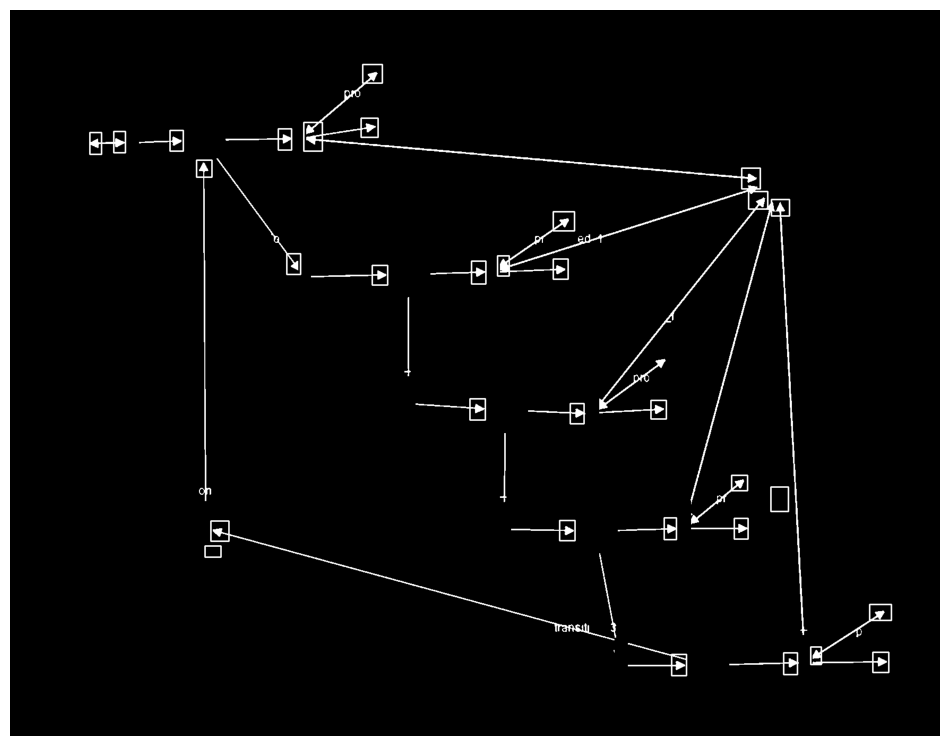

In [96]:
import supervision as sv

img_draw = img_no_shapes.copy()

# load the results into the supervision Detections api
detections = sv.Detections.from_inference(arrowhead_result)

# create supervision annotators
bounding_box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

# annotate the image with our inference results
annotated_image = bounding_box_annotator.annotate(
    scene=img_draw, detections=detections)
# annotated_image = label_annotator.annotate(
#     scene=annotated_image, detections=detections)


# display the image
sv.plot_image(annotated_image)

In [97]:
for prediction in arrowhead_result["predictions"]:
    prediction_center = Point(prediction["x"], prediction["y"])
    
    closest_point = None
    closest_distance = float("inf")
    for line in merged_lines_points:
        distance1 = prediction_center.get_distance_between_points(line.point1)
        if distance1 < closest_distance:
            closest_distance = distance1
            closest_point = line.point1

        distance2 = prediction_center.get_distance_between_points(line.point2)
        if distance2 < closest_distance:
            closest_distance = distance2
            closest_point = line.point2
    
    ### check if the closest point is None and throw error
    if closest_point is None:
        raise ValueError("No closest point found for the prediction center.")
    
    closest_point.is_arrow = True

In [98]:
def get_arrowhead_points(lines):
    """
    Get all points that are marked as arrowheads
    """
    arrowhead_points = []
    for line in merged_lines_points:
        if hasattr(line.point1, "is_arrow") and line.point1.is_arrow:
            arrowhead_points.append(line.point1)
        if hasattr(line.point2, "is_arrow") and line.point2.is_arrow:
            arrowhead_points.append(line.point2)

    return arrowhead_points
arrowhead_points = get_arrowhead_points(merged_lines_points)
len(arrowhead_points)

30

In [99]:
img_draw = cv2.cvtColor(skeleton.copy(), cv2.COLOR_GRAY2BGR)
### draw arrowheads points on the image
for point in arrowhead_points:
    cv2.circle(img_draw, (int(point.x), int(point.y)), 5, (0, 255, 0), -1)

Image.fromarray(img_draw).show()

### Linking

In [100]:
for path in found_paths_result:
    start_node = path["points"][0].proximity_node
    end_node = path["points"][-1].proximity_node

    if path["points"][-1].is_arrow:
        start_node.outgoing.append(end_node)
        end_node.incoming.append(start_node)
    if path["points"][0].is_arrow:
        start_node.incoming.append(end_node)
        end_node.outgoing.append(start_node)
    if not path["points"][-1].is_arrow and not path["points"][0].is_arrow:
        start_node.outgoing.append(end_node)
        end_node.incoming.append(start_node)

In [101]:
### draw places, transitions and arrows between them on the image
img_draw = img.copy()
for place in places:
    place.draw_on_img(img_draw)
    for outgoing in place.outgoing:
        cv2.arrowedLine(img_draw, (place.center.x, place.center.y), (outgoing.center.x, outgoing.center.y), (255, 0, 0), 2)
for transition in transitions:
    transition.draw_on_img(img_draw)
    for outgoing in transition.outgoing:
        cv2.arrowedLine(img_draw, (transition.center.x, transition.center.y), (outgoing.center.x, outgoing.center.y), (255, 0, 0), 2)

Image.fromarray(img_draw).show()
